In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint

import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('INTEL.csv', header=0, index_col='Date', parse_dates=True)

In [3]:
df1.head()

,Open,Close,High,Low,Volume
Date,,,,,
2016-01-04,33.88,33.99,34.01,33.46,27769720
2016-01-05,33.96,33.83,34.00,33.53,16686970
2016-01-06,33.25,33.08,33.52,32.80,25314490
2016-01-07,32.28,31.84,33.01,31.84,37661380
2016-01-08,32.09,31.51,32.22,31.43,29950070


In [4]:
print(len(df1))

878


In [6]:
df1.corr(method='pearson', min_periods=1)

,Open,Close,High,Low,Volume
Open,1.000000,0.997470,0.998990,0.998697,0.140169
Close,0.997470,1.000000,0.998769,0.998904,0.137108
High,0.998990,0.998769,1.000000,0.998562,0.154105
Low,0.998697,0.998904,0.998562,1.000000,0.120409
Volume,0.140169,0.137108,0.154105,0.120409,1.000000


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 878 entries, 2016-01-04 to 2019-06-28
Data columns (total 5 columns):
Open      878 non-null float64
Close     878 non-null float64
High      878 non-null float64
Low       878 non-null float64
Volume    878 non-null int64
dtypes: float64(4), int64(1)
memory usage: 81.2 KB


In [10]:
df1['LogDailyReturns'] = np.log(df1.Close/df1.Close.shift(1))

In [11]:
X = df1['LogDailyReturns']

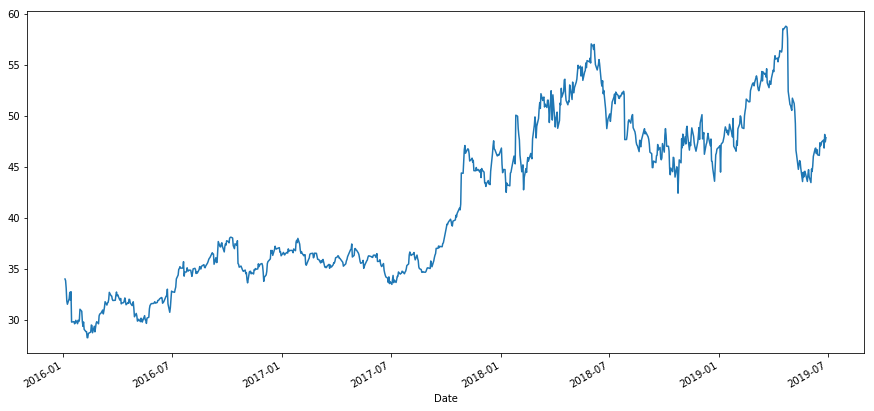

In [12]:
df1.Close.plot(figsize=(15,7))
plt.show()

In [13]:
df2 = pd.read_csv('AMD.csv', header=0, index_col='Date', parse_dates=True)

In [14]:
df2['LogDailyReturns'] = np.log(df2.Close/df2.Close.shift(1))

In [15]:
Y = df2['LogDailyReturns']

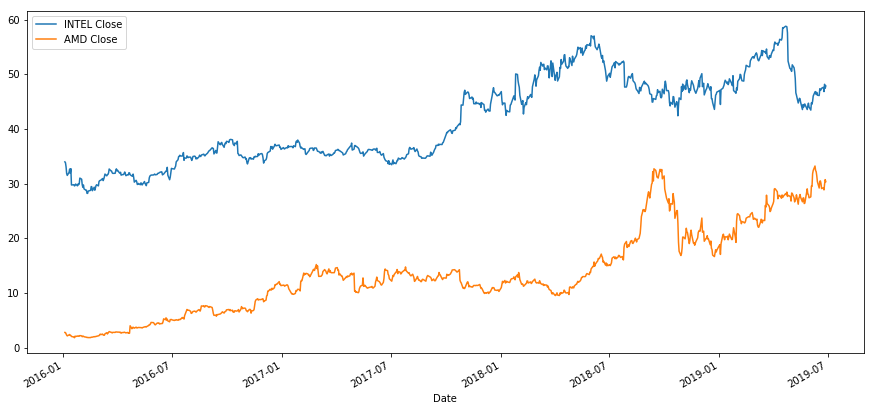

In [16]:
pd.concat([df1.Close, df2.Close], axis=1).plot(figsize=(15,7))
plt.legend(['INTEL Close', 'AMD Close'])
plt.show()

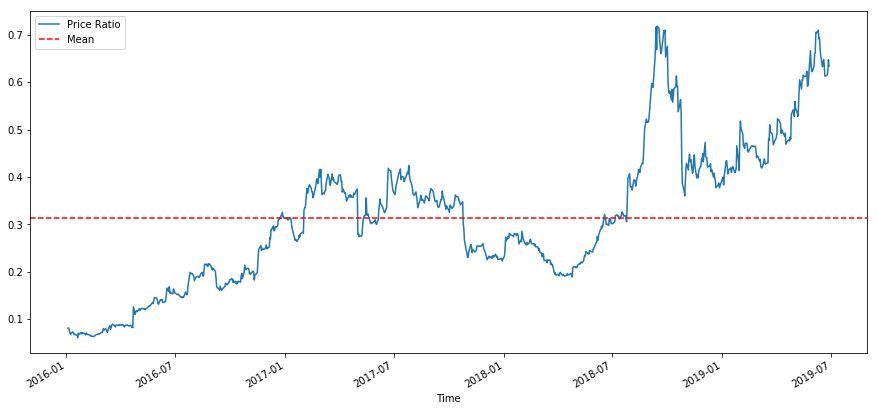

In [17]:
(df2.Close/df1.Close).plot(figsize=(15,7)) 
plt.axhline((df2.Close/df1.Close).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

In [18]:
# compute the p-value of the cointegration test
# will inform us as to whether the ratio between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(df1.Close.dropna(),df2.Close.dropna())
print (pvalue)

0.5937520179816713


In [19]:
df1.Close.corr(df2.Close)

0.6912346864814387

0.5937520179816713


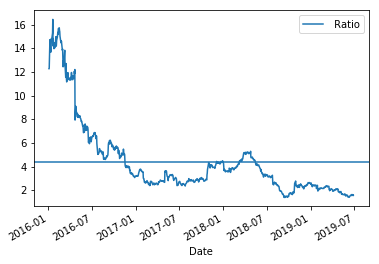

In [20]:
score, pvalue, _ = coint(df1.Close.dropna(), df2.Close.dropna())
print(pvalue)
ratios = df1.Close / df2.Close
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

In [21]:
ratios = df1.Close/ df2.Close
print(len(ratios))
train = ratios[:658]
test = ratios[658:]

878


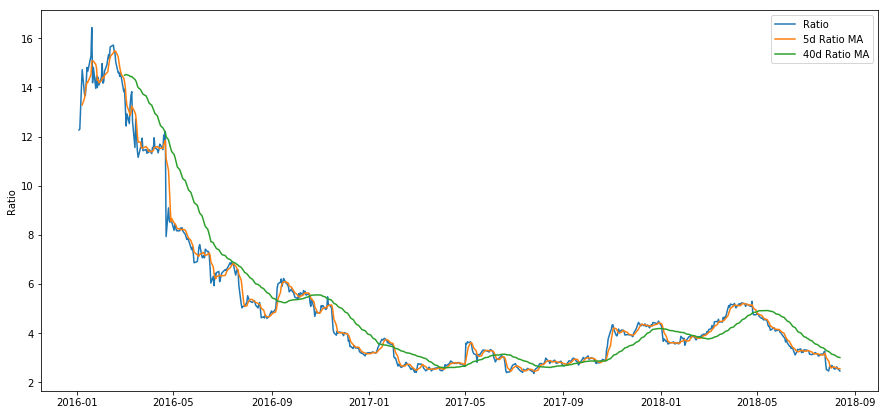

In [22]:
ratios_mavg5 = train.rolling(window=5,center=False).mean()
ratios_mavg40 = train.rolling(window=40,center=False).mean()
std_40 = train.rolling(window=40,center=False).std()
zscore_40_5 = (ratios_mavg5 - ratios_mavg40)/std_40
plt.figure(figsize=(15,7))
plt.plot(train.index, train)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg40.index, ratios_mavg40.values)
plt.legend(['Ratio','5d Ratio MA', '40d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

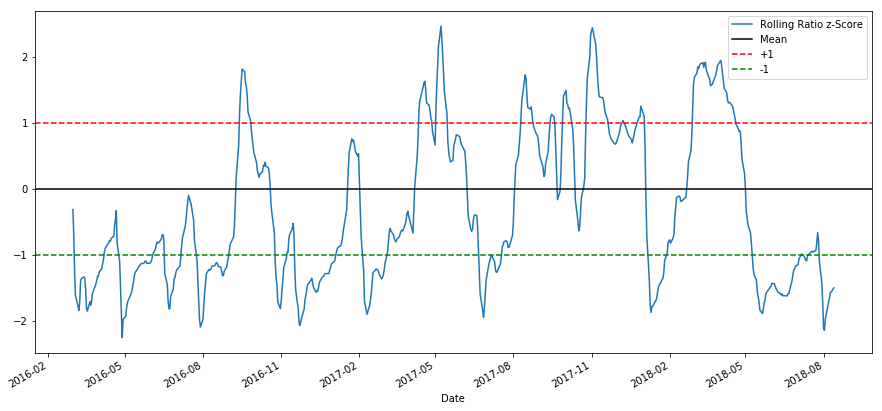

In [23]:
plt.figure(figsize=(15,7))
zscore_40_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

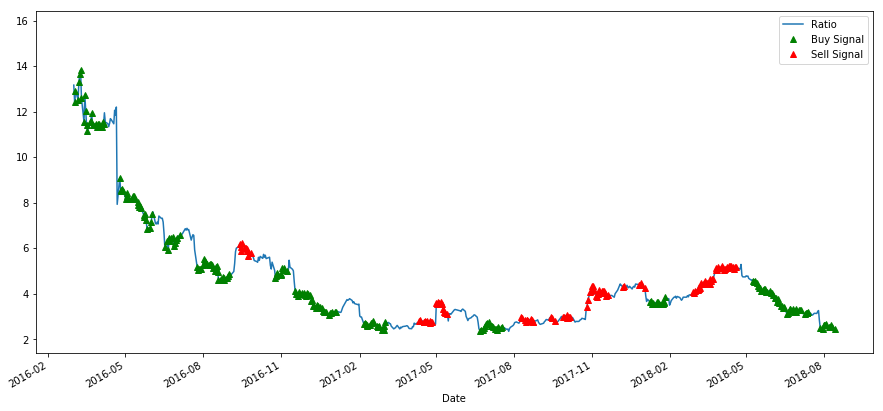

In [24]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
train[40:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_40_5>-1] = 0
sell[zscore_40_5<1] = 0
buy[40:].plot(color='g', linestyle='None', marker='^')
sell[40:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

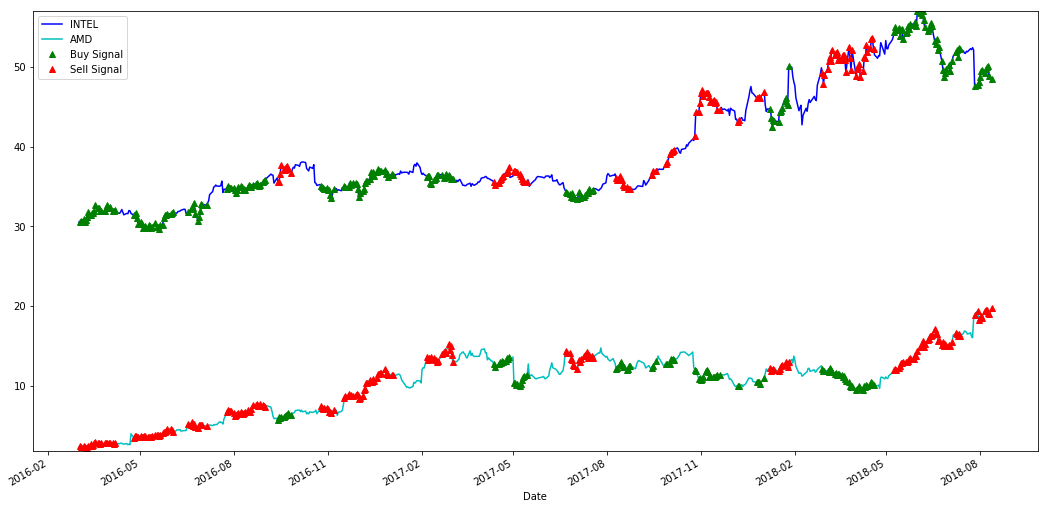

In [25]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = df1.Close.iloc[:658]
S2 = df2.Close.iloc[:658]
S1[40:].plot(color='b')
S2[40:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[40:].plot(color='g', linestyle='None', marker='^')
sellR[40:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['INTEL','AMD', 'Buy Signal', 'Sell Signal'])
plt.show()

In [26]:
ratios = S1/S2
ma1 = ratios.rolling(window=40,center=False).mean()
ma2 = ratios.rolling(window=5,center=False).mean()
std = ratios.rolling(window=5,center=False).std()
zscore = (ma1 - ma2)/std
zscore.dropna()

Date
2016-03-01     0.766604
2016-03-02     0.968658
2016-03-03     1.273942
2016-03-04     2.007536
2016-03-07     2.470801
2016-03-08     4.169581
2016-03-09     2.866771
2016-03-10     2.262799
2016-03-11     2.061662
2016-03-14     1.445124
2016-03-15     1.534862
2016-03-16     1.936293
2016-03-17     3.411690
2016-03-18     3.610369
2016-03-21     3.476480
2016-03-22     7.074176
2016-03-23     7.935876
2016-03-24     7.719947
2016-03-28    10.166481
2016-03-29     8.555497
2016-03-30     8.239464
2016-03-31    31.720877
2016-04-01    27.888537
2016-04-04    26.786184
2016-04-05    18.039931
2016-04-06    16.933613
2016-04-07     6.132935
2016-04-08     5.774300
2016-04-11     6.175324
2016-04-12     5.062216
                ...    
2018-07-02    10.800336
2018-07-03    12.042075
2018-07-05    11.615278
2018-07-06     6.153012
2018-07-09     5.015797
2018-07-10     5.487396
2018-07-11     7.348788
2018-07-12    30.205234
2018-07-13    12.505523
2018-07-16    13.016918
2018-07-17 

In [27]:
money = 100000
countS1 = 0
countS2 = 0
for i in range(len(ratios)):
    # Sell short if the z-score is > 1
    if zscore[i] > 1:
        money += S1[i] - S2[i] * ratios[i]
        countS1 -= 1
        countS2 += ratios[i]
        print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
    # Buy long if the z-score is < 1
    elif zscore[i] < -1:
        money -= S1[i] - S2[i] * ratios[i]
        countS1 += 1
        countS2 -= ratios[i]
        print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscore[i]) < 0.75:
        money += S1[i] * countS1 + S2[i] * countS2
        countS1 = 0
        countS2 = 0
        print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))

Selling Ratio 100000.0 12.430894308943088 -1 12.430894308943088
Selling Ratio 100000.0 12.924050632911392 -2 25.35494494185448
Selling Ratio 100000.0 12.526315789473683 -3 37.88126073132816
Selling Ratio 100000.0 13.28695652173913 -4 51.16821725306729
Selling Ratio 100000.0 13.659292035398233 -5 64.82750928846552
Selling Ratio 100000.0 13.827433628318586 -6 78.65494291678411
Selling Ratio 100000.0 12.603174603174605 -7 91.25811751995872
Selling Ratio 100000.0 11.555147058823529 -8 102.81326457878225
Selling Ratio 100000.0 12.710843373493974 -9 115.52410795227622
Selling Ratio 100000.0 12.049429657794677 -10 127.5735376100709
Selling Ratio 100000.0 11.421428571428573 -11 138.99496618149948
Selling Ratio 100000.0 11.15358361774744 -12 150.14854979924692
Selling Ratio 100000.0 11.550000000000002 -13 161.69854979924693
Selling Ratio 100000.0 11.584229390681003 -14 173.28277918992794
Selling Ratio 100000.0 11.940298507462686 -15 185.22307769739064
Selling Ratio 100000.0 11.42652329749104 -1

In [28]:
print(money)

100176.23990741857


In [29]:
S1 = df1.Close.iloc[658:]
S2 = df2.Close.iloc[658:]
ratios = S1/S2
ma1 = ratios.rolling(window=40,center=False).mean()
ma2 = ratios.rolling(window=5,center=False).mean()
std = ratios.rolling(window=5,center=False).std()
zscore = (ma1 - ma2)/std
zscore.dropna()

Date
2018-10-09     1.365442
2018-10-10     0.188392
2018-10-11    -0.356319
2018-10-12    -0.708701
2018-10-15    -0.717326
2018-10-16    -0.504062
2018-10-17    -0.579832
2018-10-18    -0.927115
2018-10-19    -0.739823
2018-10-22    -0.950961
2018-10-23    -1.611585
2018-10-24    -2.247660
2018-10-25    -1.260053
2018-10-26    -1.106508
2018-10-29    -1.350438
2018-10-30    -1.976492
2018-10-31    -4.744755
2018-11-01    -5.805011
2018-11-02    -4.082576
2018-11-05    -3.898824
2018-11-06    -5.343292
2018-11-07    -6.871492
2018-11-08    -7.094841
2018-11-09    -6.616726
2018-11-12    -5.057259
2018-11-13    -4.572007
2018-11-14    -4.896529
2018-11-15    -3.901355
2018-11-16    -3.946190
2018-11-19    -3.148948
                ...    
2019-05-17     8.868224
2019-05-20    21.491837
2019-05-21    23.805489
2019-05-22    24.781139
2019-05-23     8.103153
2019-05-24     6.149488
2019-05-28     3.155398
2019-05-29     3.026069
2019-05-30     2.902783
2019-05-31     3.614188
2019-06-03 

In [30]:
money = 100000
countS1 = 0
countS2 = 0
for i in range(len(ratios)):
    # Sell short if the z-score is > 1
    if zscore[i] > 1:
        money += S1[i] - S2[i] * ratios[i]
        countS1 -= 1
        countS2 += ratios[i]
        print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
    # Buy long if the z-score is < 1
    elif zscore[i] < -1:
        money -= S1[i] - S2[i] * ratios[i]
        countS1 += 1
        countS2 -= ratios[i]
        print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscore[i]) < 0.75:
        money += S1[i] * countS1 + S2[i] * countS2
        countS1 = 0
        countS2 = 0
        print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))

Selling Ratio 100000.0 1.7088839941262848 -1 1.7088839941262848
Exit pos 99997.92209985315 1.7919999999999998 0 0
Exit pos 99997.92209985315 1.7482214129731783 0 0
Exit pos 99997.92209985315 1.703872437357631 0 0
Exit pos 99997.92209985315 1.6957349581111956 0 0
Exit pos 99997.92209985315 1.630234208658623 0 0
Exit pos 99997.92209985315 1.6809524425257305 0 0
Exit pos 99997.92209985315 1.8596787827557058 0 0
Buying Ratio 99997.92209985315 1.7736149860502193 1 -1.7736149860502193
Buying Ratio 99997.92209985315 1.8613426124904515 2 -3.634957598540671
Buying Ratio 99997.92209985315 2.2994291645044114 3 -5.934386763045082
Buying Ratio 99997.92209985315 2.5916053653775024 4 -8.525992128422585
Buying Ratio 99997.92209985315 2.694362017804154 5 -11.22035414622674
Buying Ratio 99997.92209985315 2.7767440246079054 6 -13.997098170834645
Buying Ratio 99997.92209985315 2.574409806392631 7 -16.571507977227277
Buying Ratio 99997.92209985315 2.3847676748154143 8 -18.95627565204269
Buying Ratio 99997.

In [31]:
print(money)

100039.65035704187
